In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score,ConfusionMatrixDisplay,classification_report


In [ ]:

def list_files(dir):
    file_list = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".png"):
                file_list.append(os.path.join(root, file))
    return file_list

In [ ]:

data_dir = '/content/drive/MyDrive/DATA'


output_dir = '/content/drive/MyDrive/DATA'


train_val_split = 0.8
val_split = 0.1


for class_dir in os.listdir(data_dir):

    class_path = os.path.join(data_dir, class_dir)


    if not os.path.isdir(class_path):
        continue

    print(f"Processing {class_dir} class...")


    files = list_files(class_path)


    random.shuffle(files)


    num_train_val_files = int(train_val_split * len(files))
    num_val_files = int(val_split * num_train_val_files)

    train_val_files = files[:num_train_val_files]
    train_files = train_val_files[:-num_val_files]
    val_files = train_val_files[-num_val_files:]
    test_files = files[num_train_val_files:]


    train_class_dir = os.path.join(output_dir, 'train', class_dir)
    val_class_dir = os.path.join(output_dir, 'val', class_dir)
    test_class_dir = os.path.join(output_dir, 'test', class_dir)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)


    for file_path in train_files:
        file_name = os.path.basename(file_path)
        dst = os.path.join(train_class_dir, file_name)
        shutil.copy(file_path, dst)


    for file_path in val_files:
        file_name = os.path.basename(file_path)
        dst = os.path.join(val_class_dir, file_name)
        shutil.copy(file_path, dst)


    for file_path in test_files:
        file_name = os.path.basename(file_path)
        dst = os.path.join(test_class_dir, file_name)
        shutil.copy(file_path, dst)

print("Data split completed successfully.")

Processing 54 class...
Processing 5 class...
Processing 3 class...
Processing 55 class...
Processing 56 class...
Processing 35 class...
Processing 57 class...
Processing 7 class...
Processing 4 class...
Processing 30 class...
Processing 0 class...
Processing 26 class...
Processing 16 class...
Processing 11 class...
Processing 24 class...
Processing 10 class...
Processing 28 class...
Processing 17 class...
Processing 14 class...
Processing 12 class...
Data split completed successfully.


In [ ]:
class RoadSignDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform


        self.class_names = sorted(os.listdir(self.root_dir))


        self.image_paths = []
        self.labels = []


        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)


            image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]


            self.image_paths.extend([os.path.join(class_dir, img) for img in image_files])
            self.labels.extend([label_idx] * len(image_files))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

dataset_root = '/content/drive/MyDrive/DATA'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = RoadSignDataset(root_dir=dataset_root, split='train', transform=transform)
test_dataset = RoadSignDataset(root_dir=dataset_root, split='test', transform=transform)
val_dataset = RoadSignDataset(root_dir=dataset_root, split='val', transform=transform)

def get_data_loader(dataset,batch_size,shuffle):
  return DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)



Mounted at /content/drive


In [ ]:
# Training and evaluation
def train(num_epochs, model, train_loader, val_loader, criterion, optimizer, patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    total_steps = len(train_loader)

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    max_loss = float('inf')
    epoch_change = 0

    for epoch in range(num_epochs):
        losses_train = 0
        total_train = 0
        correct_train = 0

        model.train()
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses_train += loss.item()
            total_train += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        mean_loss_epoch = losses_train / total_steps
        train_loss.append(mean_loss_epoch)
        train_accuracy.append((correct_train / total_train) * 100)

        model.eval()
        losses_val = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                images_val, labels_val = data[0].to(device), data[1].to(device)
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                losses_val += loss_val.item()
                _, predicted = torch.max(outputs_val.data, 1)
                correct_val += (predicted == labels_val).sum().item()
                total_val += labels_val.size(0)

        val_epoch_loss = losses_val / len(val_loader)
        val_loss.append(val_epoch_loss)
        val_accuracy.append((correct_val / total_val) * 100)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss_epoch:.4f}, Accuracy: {(correct_train / total_train) * 100:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {(correct_val / total_val) * 100:.2f}%')

        if val_epoch_loss < max_loss:
            max_loss = val_epoch_loss
            epoch_change = 0
        else:
            epoch_change += 1

        if epoch_change >= patience:
            print(f'Early stop after {epoch+1} epochs')
            break

    return train_loss, train_accuracy, val_accuracy, model,val_loss

In [ ]:

# Evaluate the model on test set
def test(model, test_loader):
	model.eval()
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	print("Device: {}".format(device))
	torch.cuda.empty_cache()
	model.to(device)
	test_preds = []
	test_labels = []
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			_, predicted = torch.max(outputs, 1)
			test_preds.extend(predicted.cpu().numpy())
			test_labels.extend(labels.cpu().numpy())

			test_accuracy = accuracy_score(test_labels, test_preds)
			test_recall = recall_score(test_labels, test_preds,average='micro')
			test_f1score = f1_score(test_labels, test_preds,average='micro')
			test_precision=precision_score(test_labels, test_preds,average='micro')
			conf_matrix = confusion_matrix(test_labels, test_preds)
	return test_accuracy,test_recall,test_f1score,test_precision,conf_matrix


In [ ]:
from sklearn.manifold import TSNE
import numpy as np
def extract_features(model, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            labels.extend(labels_batch.numpy())
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features), np.array(labels)

def plot_tsne(train_features, train_labels, test_features, test_labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42)
    train_features_tsne = tsne.fit_transform(train_features)
    test_features_tsne = tsne.fit_transform(test_features)

    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    for i in range(len(train_dataset.class_names)):
        plt.scatter(train_features_tsne[train_labels == i, 0], train_features_tsne[train_labels == i, 1], label=f'{train_dataset.class_names[i]} (Train)', marker='o', alpha=0.5)
    plt.title(f't-SNE visualization of Train data')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(test_dataset.class_names)):
        plt.scatter(test_features_tsne[test_labels == i, 0], test_features_tsne[test_labels == i, 1], label=f'{test_dataset.class_names[i]} (Test)', marker='x', alpha=0.5)
    plt.title(f't-SNE visualization of Test data')
    plt.legend()

    plt.suptitle(f't-SNE visualization of {dataset_name} data', fontsize=16)
    plt.show()

Results of the batch_size=16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.2374, Accuracy: 32.98%, Val Loss: 1.6955, Val Accuracy: 48.56%
Epoch [2/25], Loss: 1.4797, Accuracy: 53.41%, Val Loss: 1.3525, Val Accuracy: 60.08%
Epoch [3/25], Loss: 1.1569, Accuracy: 66.27%, Val Loss: 1.1600, Val Accuracy: 68.31%
Epoch [4/25], Loss: 0.8786, Accuracy: 75.86%, Val Loss: 0.8736, Val Accuracy: 76.95%
Epoch [5/25], Loss: 0.6590, Accuracy: 82.60%, Val Loss: 0.6436, Val Accuracy: 82.72%
Epoch [6/25], Loss: 0.4857, Accuracy: 88.00%, Val Loss: 0.4626, Val Accuracy: 90.95%
Epoch [7/25], Loss: 0.3303, Accuracy: 92.90%, Val Loss: 0.4395, Val Accuracy: 91.36%
Epoch [8/25], Loss: 0.2335, Accuracy: 95.58%, Val Loss: 0.5076, Val Accuracy: 94.65%
Epoch [9/25], Loss: 0.1877, Accuracy: 96.39%, Val Loss: 0.3465, Val Accuracy: 93.00%
Epoch [10/25], Loss: 0.1368, Accuracy: 97.77%, Val Loss: 0.3650, Val Accuracy: 95.47%
Epoch [11/25], Loss: 0.0990, Accuracy: 99.02%, Val Loss: 0.2423, Val Accuracy: 94.65%
Epoch [12/25], Loss: 0.0870, Accuracy: 98.93%, Val Loss: 0.2407

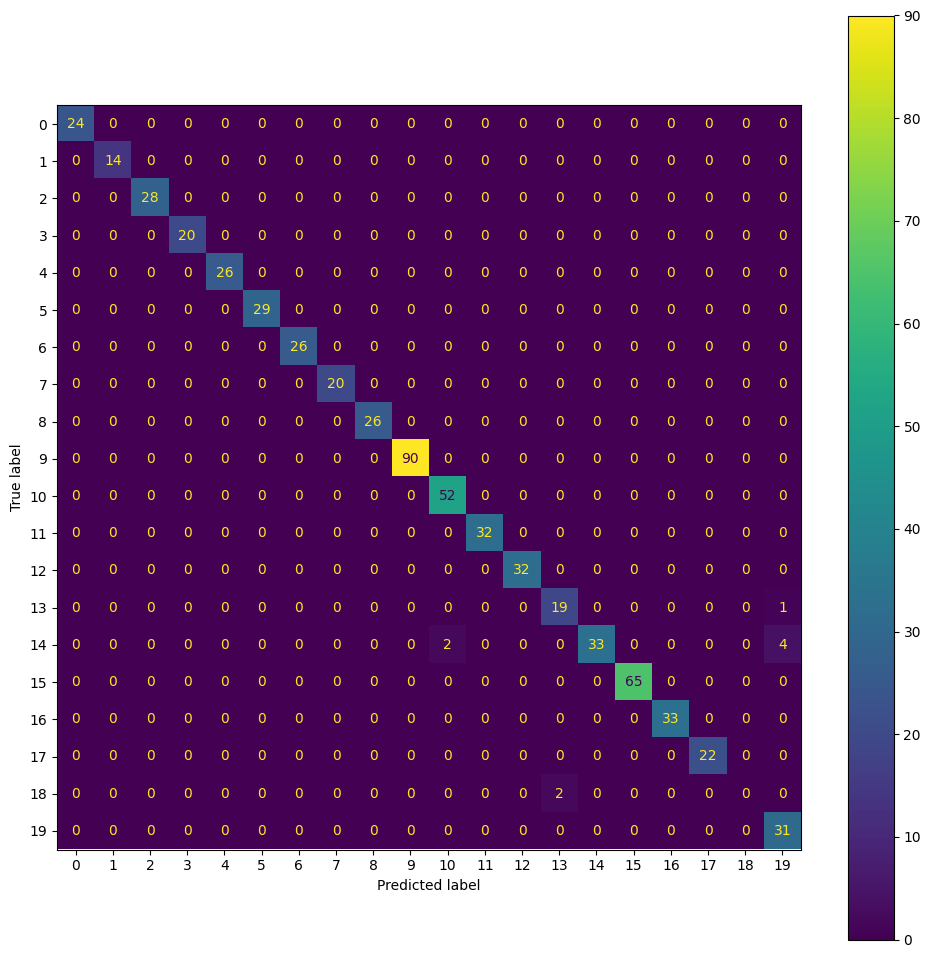

Results of the batch_size=32


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.5123, Accuracy: 25.21%, Val Loss: 2.0902, Val Accuracy: 34.16%
Epoch [2/25], Loss: 1.8178, Accuracy: 45.56%, Val Loss: 1.6147, Val Accuracy: 49.79%
Epoch [3/25], Loss: 1.4512, Accuracy: 55.38%, Val Loss: 1.4064, Val Accuracy: 60.08%
Epoch [4/25], Loss: 1.2435, Accuracy: 61.27%, Val Loss: 1.2395, Val Accuracy: 64.20%
Epoch [5/25], Loss: 1.0734, Accuracy: 69.21%, Val Loss: 1.4501, Val Accuracy: 53.91%
Epoch [6/25], Loss: 0.9367, Accuracy: 73.94%, Val Loss: 1.1028, Val Accuracy: 65.84%
Epoch [7/25], Loss: 0.7880, Accuracy: 78.85%, Val Loss: 0.8898, Val Accuracy: 76.13%
Epoch [8/25], Loss: 0.6649, Accuracy: 82.15%, Val Loss: 0.9252, Val Accuracy: 75.31%
Epoch [9/25], Loss: 0.5596, Accuracy: 86.66%, Val Loss: 0.7287, Val Accuracy: 81.89%
Epoch [10/25], Loss: 0.4603, Accuracy: 88.71%, Val Loss: 0.6143, Val Accuracy: 84.36%
Epoch [11/25], Loss: 0.4002, Accuracy: 91.39%, Val Loss: 0.6696, Val Accuracy: 82.30%
Epoch [12/25], Loss: 0.3292, Accuracy: 94.02%, Val Loss: 0.4287

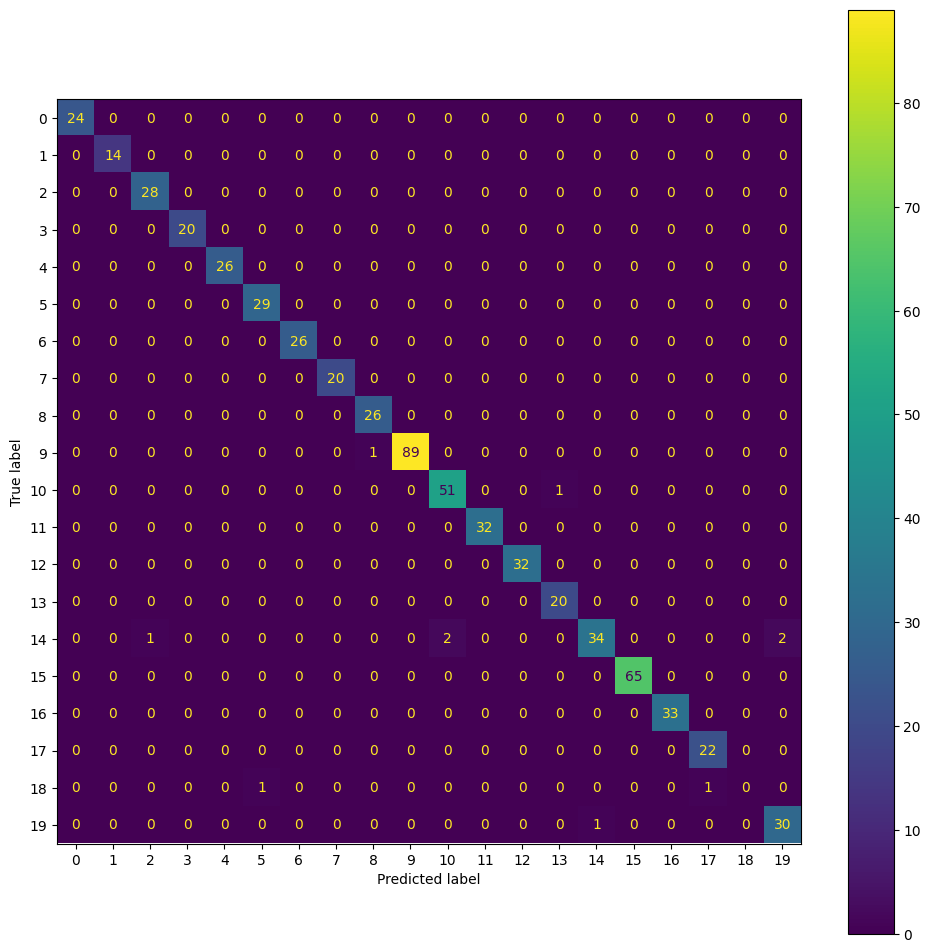

Results of the batch_size=64


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.7297, Accuracy: 18.03%, Val Loss: 2.7640, Val Accuracy: 20.99%
Epoch [2/25], Loss: 2.2551, Accuracy: 30.79%, Val Loss: 2.0061, Val Accuracy: 39.51%
Epoch [3/25], Loss: 1.8569, Accuracy: 41.41%, Val Loss: 1.7785, Val Accuracy: 42.39%
Epoch [4/25], Loss: 1.5972, Accuracy: 52.66%, Val Loss: 1.6287, Val Accuracy: 49.79%
Epoch [5/25], Loss: 1.4360, Accuracy: 56.22%, Val Loss: 1.3824, Val Accuracy: 58.44%
Epoch [6/25], Loss: 1.3077, Accuracy: 60.73%, Val Loss: 1.5605, Val Accuracy: 52.26%
Epoch [7/25], Loss: 1.1907, Accuracy: 64.03%, Val Loss: 1.5496, Val Accuracy: 55.14%
Epoch [8/25], Loss: 1.0787, Accuracy: 70.33%, Val Loss: 1.2766, Val Accuracy: 61.32%
Epoch [9/25], Loss: 1.0206, Accuracy: 71.49%, Val Loss: 1.1742, Val Accuracy: 64.61%
Epoch [10/25], Loss: 0.9270, Accuracy: 73.27%, Val Loss: 1.2654, Val Accuracy: 64.20%
Epoch [11/25], Loss: 0.8561, Accuracy: 76.66%, Val Loss: 0.9589, Val Accuracy: 69.55%
Epoch [12/25], Loss: 0.8197, Accuracy: 78.71%, Val Loss: 0.9119

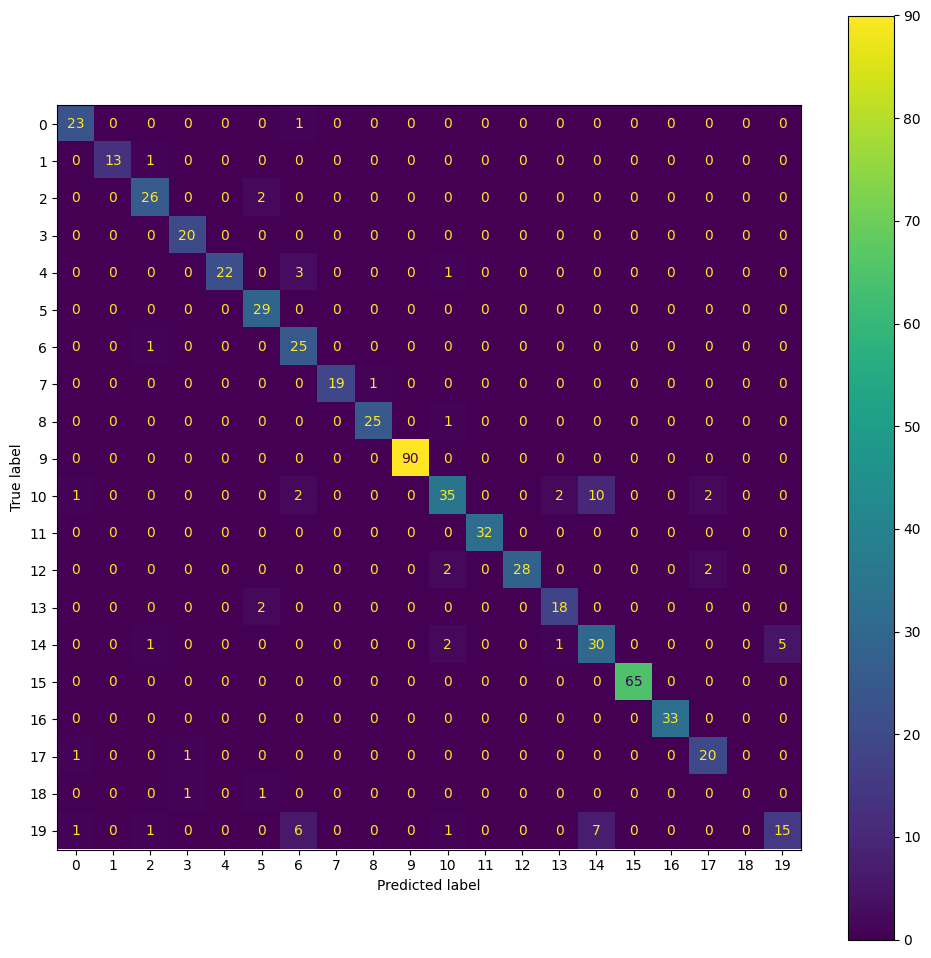

In [ ]:
train_loss_hyperparameters1={}
train_acc_hyperparameters1={}
val_acc_hyperparameters1={}
learning_rate=0.0001
hyper_parameters={"batch_size":[16,32,64]}
num_epochs=25

for batch_size in hyper_parameters["batch_size"]:
  print('==========')
  print(f'Results of the batch_size={batch_size}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model = models.resnet18(pretrained=False)

  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs,20)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters1[f"lr{batch_size}"]=train_loss
  train_acc_hyperparameters1[f"lr{batch_size}"]=train_accuracy
  val_acc_hyperparameters1[f"lr{batch_size}"]=val_accuracy


  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()

In [ ]:
train_loss_hyperparameters={}
train_acc_hyperparameters={}
val_acc_hyperparameters={}
batch_size=32
hyper_parameters={"learning_rate":[0.001,0.0001]}
num_epochs=25


for learning_rate in hyper_parameters["learning_rate"]:
  print('==========')
  print(f'Results of the learning rate={learning_rate}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model2 = models.resnet18(pretrained=False)

  num_ftrs = model2.fc.in_features
  model2.fc = nn.Linear(num_ftrs,20)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)



  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model2,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters[f"lr{learning_rate}"]=train_loss
  train_acc_hyperparameters[f"lr{learning_rate}"]=train_accuracy
  val_acc_hyperparameters[f"lr{learning_rate}"]=val_accuracy


  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model2, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)


Results of the learning rate=0.001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.5681, Accuracy: 24.45%, Val Loss: 2.1382, Val Accuracy: 33.33%
Epoch [2/25], Loss: 1.7363, Accuracy: 47.03%, Val Loss: 1.5843, Val Accuracy: 50.21%
Epoch [3/25], Loss: 1.4315, Accuracy: 54.57%, Val Loss: 1.3933, Val Accuracy: 55.14%
Epoch [4/25], Loss: 1.2318, Accuracy: 62.78%, Val Loss: 1.4545, Val Accuracy: 53.09%
Epoch [5/25], Loss: 1.1132, Accuracy: 65.77%, Val Loss: 1.0990, Val Accuracy: 72.02%
Epoch [6/25], Loss: 0.9427, Accuracy: 74.48%, Val Loss: 1.0325, Val Accuracy: 66.26%
Epoch [7/25], Loss: 0.8273, Accuracy: 78.49%, Val Loss: 0.9126, Val Accuracy: 69.96%
Epoch [8/25], Loss: 0.6999, Accuracy: 81.66%, Val Loss: 0.7791, Val Accuracy: 76.95%
Epoch [9/25], Loss: 0.5838, Accuracy: 85.27%, Val Loss: 0.7069, Val Accuracy: 79.84%
Epoch [10/25], Loss: 0.4853, Accuracy: 89.65%, Val Loss: 0.6136, Val Accuracy: 85.19%
Epoch [11/25], Loss: 0.4003, Accuracy: 92.24%, Val Loss: 0.5863, Val Accuracy: 87.24%
Epoch [12/25], Loss: 0.3195, Accuracy: 94.24%, Val Loss: 0.6464

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.5353, Accuracy: 24.99%, Val Loss: 2.0382, Val Accuracy: 37.04%
Epoch [2/25], Loss: 1.7654, Accuracy: 45.74%, Val Loss: 1.9243, Val Accuracy: 41.56%
Epoch [3/25], Loss: 1.4241, Accuracy: 56.18%, Val Loss: 1.4561, Val Accuracy: 55.97%
Epoch [4/25], Loss: 1.1886, Accuracy: 64.21%, Val Loss: 1.2476, Val Accuracy: 66.26%
Epoch [5/25], Loss: 1.0118, Accuracy: 72.07%, Val Loss: 1.0478, Val Accuracy: 70.78%
Epoch [6/25], Loss: 0.8466, Accuracy: 77.87%, Val Loss: 1.1912, Val Accuracy: 68.72%
Epoch [7/25], Loss: 0.7246, Accuracy: 80.99%, Val Loss: 0.9646, Val Accuracy: 71.60%
Epoch [8/25], Loss: 0.6359, Accuracy: 84.29%, Val Loss: 1.1427, Val Accuracy: 68.72%
Epoch [9/25], Loss: 0.5098, Accuracy: 88.17%, Val Loss: 1.0878, Val Accuracy: 69.55%
Epoch [10/25], Loss: 0.4407, Accuracy: 91.43%, Val Loss: 0.6924, Val Accuracy: 83.54%
Epoch [11/25], Loss: 0.3939, Accuracy: 91.83%, Val Loss: 0.5037, Val Accuracy: 88.48%
Epoch [12/25], Loss: 0.3135, Accuracy: 94.82%, Val Loss: 0.4574

In [ ]:
train_loss_hyperparameters2={}
train_acc_hyperparameters2={}
val_acc_hyperparameters2={}
learning_rate=0.0001
hyper_parameters={"loss_function":["neg_log_likelihood","cross_entropy"]}
num_epochs=25
batch_size=32

for loss_function in hyper_parameters["loss_function"]:
  print('==========')
  print(f'Results of the loss_function={loss_function}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model1 = models.resnet18(pretrained=False)
  num_ftrs = model1.fc.in_features
  model1.fc = nn.Linear(num_ftrs,20)
  if loss_function=="neg_log_likelihood":
    criterion=nn.NLLLoss()
  elif loss_function=="cross_entropy":
    criterion=nn.CrossEntropyLoss()
  optimizer=torch.optim.SGD(model1.parameters(),lr=learning_rate)
  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model1,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters2[f"lfn{loss_function}"]=train_loss
  train_acc_hyperparameters2[f"lfn{loss_function}"]=train_accuracy
  val_acc_hyperparameters2[f"lfn{loss_function}"]=val_accuracy



  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model1, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)


Results of the loss_function=neg_log_likelihood


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 0.0321, Accuracy: 10.31%, Val Loss: -0.0722, Val Accuracy: 13.99%
Epoch [2/25], Loss: -0.1345, Accuracy: 14.23%, Val Loss: -0.2407, Val Accuracy: 14.40%
Epoch [3/25], Loss: -0.3106, Accuracy: 14.68%, Val Loss: -0.3916, Val Accuracy: 14.81%
Epoch [4/25], Loss: -0.4544, Accuracy: 14.32%, Val Loss: -0.5577, Val Accuracy: 13.99%
Epoch [5/25], Loss: -0.6507, Accuracy: 14.37%, Val Loss: -0.7298, Val Accuracy: 14.40%
Epoch [6/25], Loss: -0.8229, Accuracy: 14.32%, Val Loss: -0.9273, Val Accuracy: 14.40%
Epoch [7/25], Loss: -0.9700, Accuracy: 14.32%, Val Loss: -1.0510, Val Accuracy: 14.40%
Epoch [8/25], Loss: -1.1547, Accuracy: 14.32%, Val Loss: -1.2859, Val Accuracy: 14.40%
Epoch [9/25], Loss: -1.3152, Accuracy: 14.32%, Val Loss: -1.4662, Val Accuracy: 14.40%
Epoch [10/25], Loss: -1.4989, Accuracy: 14.32%, Val Loss: -1.7064, Val Accuracy: 14.40%
Epoch [11/25], Loss: -1.7130, Accuracy: 14.32%, Val Loss: -1.7834, Val Accuracy: 14.40%
Epoch [12/25], Loss: -1.8715, Accuracy: 14

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 3.0901, Accuracy: 2.23%, Val Loss: 3.0621, Val Accuracy: 2.88%
Epoch [2/25], Loss: 3.0078, Accuracy: 4.55%, Val Loss: 3.0254, Val Accuracy: 5.76%
Epoch [3/25], Loss: 2.9643, Accuracy: 9.24%, Val Loss: 2.9435, Val Accuracy: 16.05%
Epoch [4/25], Loss: 2.9126, Accuracy: 17.89%, Val Loss: 2.9381, Val Accuracy: 17.28%
Epoch [5/25], Loss: 2.8750, Accuracy: 19.72%, Val Loss: 2.8962, Val Accuracy: 18.52%
Epoch [6/25], Loss: 2.8398, Accuracy: 19.46%, Val Loss: 2.8484, Val Accuracy: 18.52%
Epoch [7/25], Loss: 2.8212, Accuracy: 19.28%, Val Loss: 2.8274, Val Accuracy: 18.52%
Epoch [8/25], Loss: 2.7824, Accuracy: 19.46%, Val Loss: 2.8026, Val Accuracy: 18.52%
Epoch [9/25], Loss: 2.7724, Accuracy: 19.46%, Val Loss: 2.7775, Val Accuracy: 18.11%
Epoch [10/25], Loss: 2.7551, Accuracy: 19.72%, Val Loss: 2.7469, Val Accuracy: 18.52%
Epoch [11/25], Loss: 2.7152, Accuracy: 19.95%, Val Loss: 2.7481, Val Accuracy: 18.52%
Epoch [12/25], Loss: 2.6995, Accuracy: 19.81%, Val Loss: 2.7159, Val

In [ ]:
!pip install flopper
from flopper import count_flops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

Results of the batch_size=32


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FLOPs of the model ResNet: 1.83 GFLOPs
Number of FLOPs: <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7b783d34f340>
Epoch [1/25], Loss: 2.4969, Accuracy: 25.84%, Val Loss: 2.1564, Val Accuracy: 37.04%
Epoch [2/25], Loss: 1.7479, Accuracy: 45.56%, Val Loss: 2.1754, Val Accuracy: 41.98%
Epoch [3/25], Loss: 1.4556, Accuracy: 55.87%, Val Loss: 1.4892, Val Accuracy: 58.44%
Epoch [4/25], Loss: 1.2542, Accuracy: 62.43%, Val Loss: 1.2608, Val Accuracy: 65.84%
Epoch [5/25], Loss: 1.0985, Accuracy: 67.29%, Val Loss: 1.2312, Val Accuracy: 64.61%
Epoch [6/25], Loss: 0.9540, Accuracy: 72.78%, Val Loss: 1.0041, Val Accuracy: 71.19%
Epoch [7/25], Loss: 0.8101, Accuracy: 78.36%, Val Loss: 0.8811, Val Accuracy: 74.49%
Epoch [8/25], Loss: 0.6951, Accuracy: 80.99%, Val Loss: 0.9862, Val Accuracy: 76.13%
Epoch [9/25], Loss: 0.5978, Accuracy: 85.36%, Val Loss: 0.7599, Val Accuracy: 81.89%
Epoch [10/25], Loss: 0.4887, Accuracy: 89.92%, Val Loss: 0.8374, Val Accuracy: 77.78%
Epoch [11/25], Loss: 0.3909

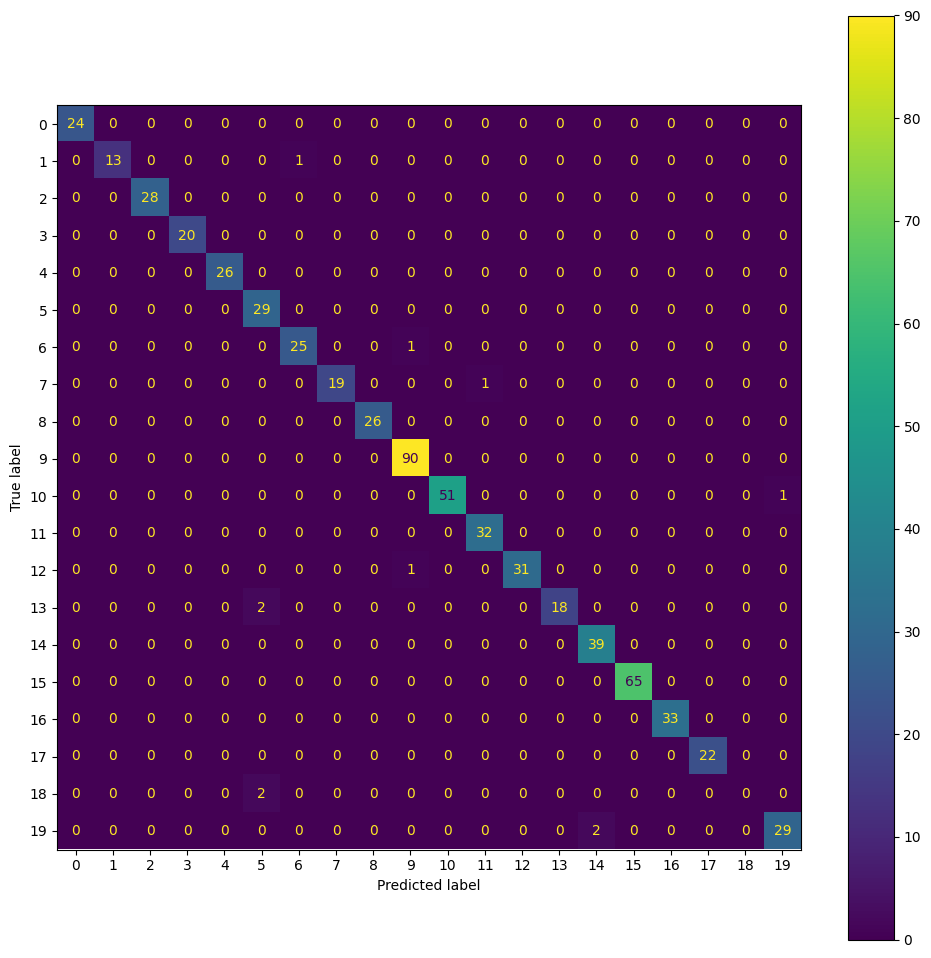

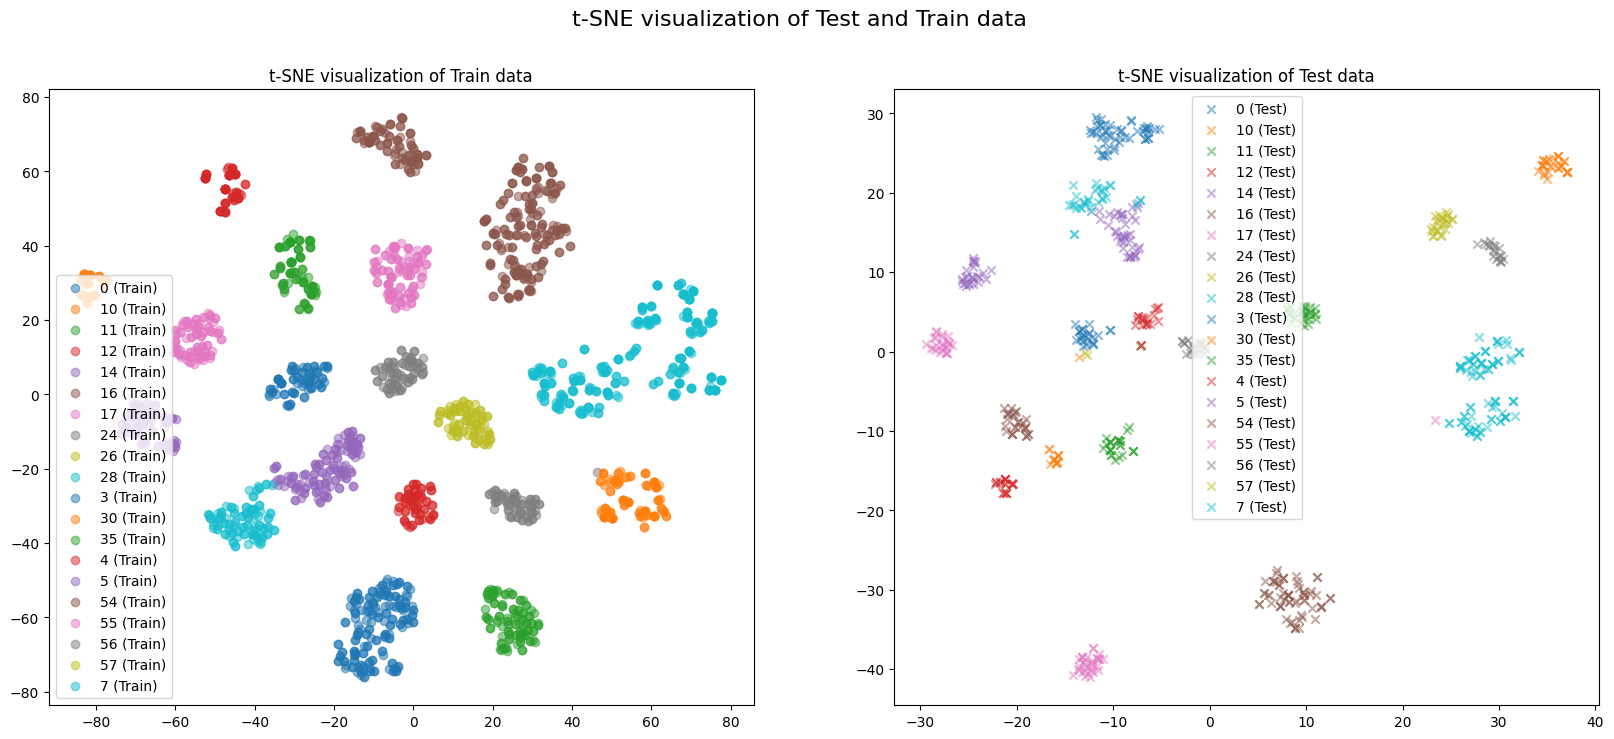

In [ ]:
#final hyperparameters batch_size = 32, lr = 0.0001, cross entrop loss

train_loss_hyperparameters3={}
train_acc_hyperparameters3={}
val_acc_hyperparameters3={}
val_loss_hyperparameters3={}
learning_rate=0.0001
hyper_parameters={"batch_size":[32]}
num_epochs=25

for batch_size in hyper_parameters["batch_size"]:
  print('==========')
  print(f'Results of the batch_size={batch_size}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model4 = models.resnet18(pretrained=False)
  batch = torch.randn(1, 3, 224, 224)
  flops = count_flops(model4, batch)
  print(f"Number of FLOPs: {flops}")
  num_ftrs = model4.fc.in_features
  model4.fc = nn.Linear(num_ftrs,20)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)

  train_loss,train_accuracy,val_accuracy,model4,val_loss=train(num_epochs,model4,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters3[f"lr{batch_size}"]=train_loss
  train_acc_hyperparameters3[f"lr{batch_size}"]=train_accuracy
  val_acc_hyperparameters3[f"lr{batch_size}"]=val_accuracy
  val_loss_hyperparameters3[f"lr{batch_size}"]=val_loss

  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model4, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()
  train_features, train_labels = extract_features(model4, train_loader)
  test_features, test_labels = extract_features(model4, test_loader)
  plot_tsne(train_features, train_labels, test_features, test_labels, "Test and Train")

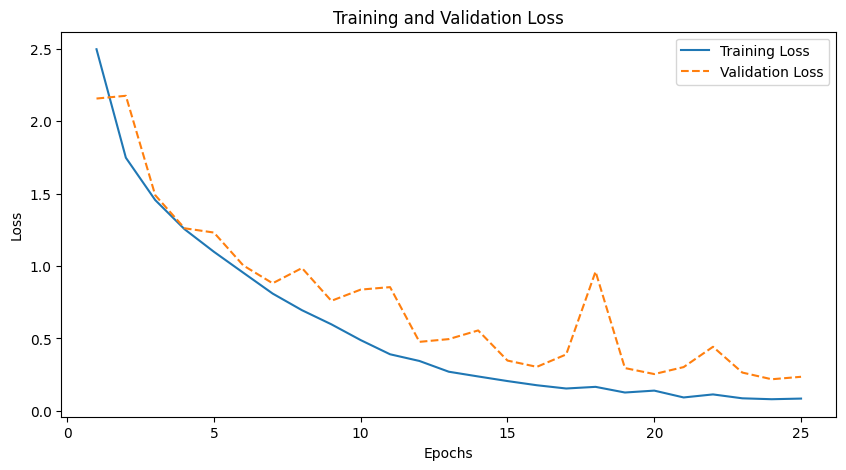

In [ ]:
key = f"lr{batch_size}"
if key in train_loss_hyperparameters3 and key in val_acc_hyperparameters3:
    num_epochs_actual = len(train_loss_hyperparameters3[key])
    epochs = list(range(1, num_epochs_actual + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_hyperparameters3[key], label='Training Loss')
    plt.plot(epochs, val_loss_hyperparameters3[key], label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

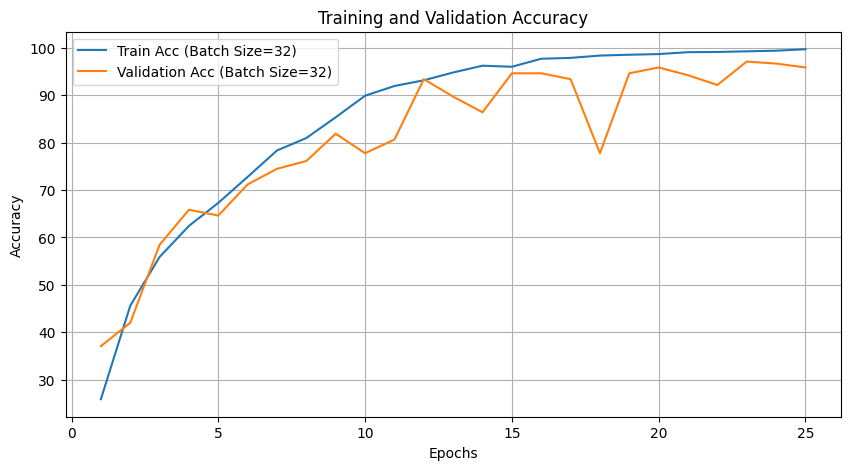

In [ ]:
key = f"lr{batch_size}"
if key in train_loss_hyperparameters3 and key in val_acc_hyperparameters3:
    num_epochs_actual = len(train_loss_hyperparameters3[key])
    epochs = list(range(1, num_epochs_actual + 1))
    plt.figure(figsize=(10, 5))
    for batch_size in hyper_parameters["batch_size"]:
        plt.plot(epochs, train_acc_hyperparameters3[f"lr{batch_size}"], label=f'Train Acc (Batch Size={batch_size})')
        plt.plot(epochs, val_acc_hyperparameters3[f"lr{batch_size}"], label=f'Validation Acc (Batch Size={batch_size})')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()